In [21]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli, morris
from SALib.analyze import sobol, morris as morris_analyze

## Toggle switch

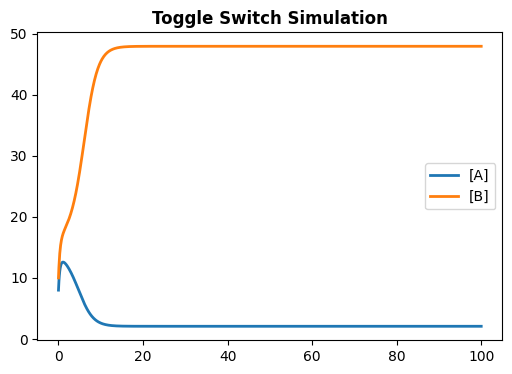

In [22]:
# ============================================================
# Load model
# ============================================================

antimony_str = """
model toggle_switch()
  species A, B;

  k1 = 50;
  k2 = 50;
  dA = 1;
  dB = 1;
  K  = 10;
  n  = 2;

  J1: -> A; k1 / (1 + (B/K)^n);
  J2: -> B; k2 / (1 + (A/K)^n);
  J3: A -> ; dA*A;
  J4: B -> ; dB*B;

end
"""

model = te.loada(antimony_str)

# Helper to create a fresh model instance
def new_model():
    return te.loada(antimony_str)

# ============================================================
# INITIAL CONDITIONS & SIMULATION
# ============================================================

model.reset()
model.A = 8
model.B = 10

result = model.simulate(0, 100, 1000)
model.plot(result, title="Toggle Switch Simulation")

In [4]:
# ============================================================
# LOCAL SENSITIVITY ANALYSIS
# ============================================================

def steady_state_A(m):
    """Compute steady-state value of A."""
    m.steadyState()
    return m.A

params = ["k1", "k2", "dA", "dB", "K", "n"]
sens_local = {}

print("\n=== LOCAL SENSITIVITY ANALYSIS ===\n")

baseline_model = new_model()
baseline_model.A = 8
baseline_model.B = 10
baseline = steady_state_A(baseline_model)

print(f"Baseline steady-state A = {baseline}")

for p in params:
    m = new_model()

    # same initial conditions
    m.A = 8
    m.B = 10

    value = m.getValue(p)
    delta = 0.01 * value if value != 0 else 0.01

    m.setValue(p, value + delta)
    perturbed = steady_state_A(m)

    sensitivity = (perturbed - baseline) / delta
    sens_local[p] = sensitivity

    print(f"Sensitivity dAss/d{p} = {sensitivity}")


=== LOCAL SENSITIVITY ANALYSIS ===

Baseline steady-state A = 15.159802276925792
Sensitivity dAss/dk1 = -0.317748070287621
Sensitivity dAss/dk2 = 0.44698993331475023
Sensitivity dAss/ddA = 16.13980380034903
Sensitivity dAss/ddB = -22.279964226024696
Sensitivity dAss/dK = 0.880333555392081
Sensitivity dAss/dn = -1.8237262409949828


In [ ]:
# ============================================================
# GLOBAL SENSITIVITY (SOBOL)
# ============================================================

print("\n=== GLOBAL SENSITIVITY ANALYSIS ===\n")

problem = {
    "num_vars": 6,
    "names": ["k1", "k2", "dA", "dB", "K", "n"],
    "bounds": [
        [10, 100],
        [10, 100],
        [0.1, 2],
        [0.1, 2],
        [1, 50],
        [1, 4],
    ]
}

def evaluate(params):
    m = new_model()
    m.A = 8
    m.B = 10
    m.k1, m.k2, m.dA, m.dB, m.K, m.n = params

    try:
        # your metric: steady-state A
        return steady_state_A(m)
    except:
        # avoid NaNs – replace with some fallback
        # (mean or baseline, or 0; here we'll use 0)
        return 0.0

# ---------------------------
# SOBOL (first-order + total)
# ---------------------------

# Disable second-order indices to simplify
param_values = saltelli.sample(problem, 512, calc_second_order=False)

Y = np.array([evaluate(p) for p in param_values])

# DO NOT drop rows here – keep length intact
# If any NaNs still appear, replace them numerically:
if np.any(np.isnan(Y)):
    # Replace NaNs with mean of non-NaN values (or 0)
    finite_mean = np.nanmean(Y)
    Y = np.nan_to_num(Y, nan=finite_mean)

Si = sobol.analyze(
    problem,
    Y,
    calc_second_order=False,  # must match sample()
    print_to_console=True
)

print("\nSobol Sensitivity (S1 and ST):")
for name, s1, st in zip(problem["names"], Si["S1"], Si["ST"]):
    print(f"{name}: S1={s1:.4f}, ST={st:.4f}")



=== GLOBAL SENSITIVITY ANALYSIS ===



C:\Users\grilj\AppData\Local\Temp\ipykernel_38888\2647499074.py:39: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`



          ST   ST_conf
k1  0.758467  0.291653
k2  0.787700  0.273611
dA  1.435781  1.700390
dB  0.723193  0.379843
K   1.321389  0.719519
n   0.678679  0.320264
          S1   S1_conf
k1  0.012751  0.050789
k2  0.005204  0.067917
dA -0.008308  0.091665
dB  0.009679  0.050025
K   0.061691  0.103613
n   0.055089  0.084997

Sobol Sensitivity (S1 and ST):
k1: S1=0.0128, ST=0.7585
k2: S1=0.0052, ST=0.7877
dA: S1=-0.0083, ST=1.4358
dB: S1=0.0097, ST=0.7232
K: S1=0.0617, ST=1.3214
n: S1=0.0551, ST=0.6787


TypeError: 'module' object is not callable


=== MORRIS GLOBAL SENSITIVITY (TOGGLE SWITCH) ===

            mu     mu_star       sigma  mu_star_conf
k1  131.542473  131.542473  201.983735     29.985356
k2  -38.757917   38.757919   73.125085      9.256764
dA -205.097148  205.097148  309.604264     37.673237
dB   39.163074   39.163074   67.127627      8.784322
K    11.447413   20.334615   65.289835      8.008422
n     3.202799   17.698204   49.709356      7.222220

=== Morris μ* (Overall Importance) ===
k1: μ* = 131.5425
k2: μ* = 38.7579
dA: μ* = 205.0971
dB: μ* = 39.1631
K: μ* = 20.3346
n: μ* = 17.6982

=== Morris σ (Nonlinearity / Interactions) ===
k1: σ = 201.9837
k2: σ = 73.1251
dA: σ = 309.6043
dB: σ = 67.1276
K: σ = 65.2898
n: σ = 49.7094


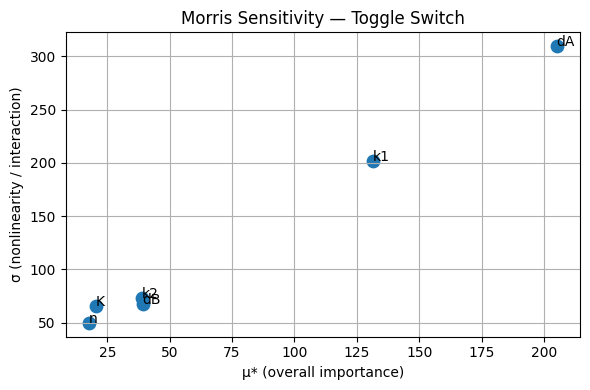

In [23]:
# ============================================================
# MORRIS GLOBAL SENSITIVITY ANALYSIS
# ============================================================

# Morris problem definition
problem_toggle = {
    "num_vars": 6,
    "names": ["k1", "k2", "dA", "dB", "K", "n"],
    "bounds": [
        [10, 100],   # k1
        [10, 100],   # k2
        [0.1,  2],   # dA
        [0.1,  2],   # dB
        [1,   50],   # K
        [1,    4],   # n
    ],
}

# ------------------------------------------------------------
# Metric: A at final simulation time
# (fast, branch-consistent for bistable systems)
# ------------------------------------------------------------

def metric_A_final(m, t_end=50, n_points=300):
    r = m.simulate(0, t_end, n_points)
    return r[-1, 1]  # column 1 = A

# ------------------------------------------------------------
# Morris evaluation function
# ------------------------------------------------------------

def evaluate_toggle_morris(params):
    m = new_model()

    # fixed initial conditions (important!)
    m.A = 8
    m.B = 10

    # unpack parameters
    m.k1, m.k2, m.dA, m.dB, m.K, m.n = params

    try:
        return metric_A_final(m)
    except:
        return 0.0  # Morris allows arbitrary outputs

# ------------------------------------------------------------
# Run Morris sampling
# ------------------------------------------------------------

print("\n=== MORRIS GLOBAL SENSITIVITY (TOGGLE SWITCH) ===\n")

morris_samples = morris.sample(
    problem_toggle,
    N=200,          # number of trajectories
    num_levels=8
)

# Evaluate model
Y_morris = np.array([evaluate_toggle_morris(p) for p in morris_samples])

# Morris allows filtering NaNs
valid = ~np.isnan(Y_morris)
morris_samples = morris_samples[valid]
Y_morris = Y_morris[valid]

# ------------------------------------------------------------
# Morris analysis
# ------------------------------------------------------------

morris_results = morris_analyze.analyze(
    problem_toggle,
    morris_samples,
    Y_morris,
    print_to_console=True
)

# ------------------------------------------------------------
# Print results
# ------------------------------------------------------------

print("\n=== Morris μ* (Overall Importance) ===")
for name, mu in zip(problem_toggle["names"], morris_results["mu_star"]):
    print(f"{name}: μ* = {mu:.4f}")

print("\n=== Morris σ (Nonlinearity / Interactions) ===")
for name, sig in zip(problem_toggle["names"], morris_results["sigma"]):
    print(f"{name}: σ = {sig:.4f}")

# ------------------------------------------------------------
# Morris μ*–σ plot (recommended for report)
# ------------------------------------------------------------

plt.figure(figsize=(6, 4))
plt.scatter(morris_results["mu_star"], morris_results["sigma"], s=80)

for i, name in enumerate(problem_toggle["names"]):
    plt.text(
        morris_results["mu_star"][i],
        morris_results["sigma"][i],
        name
    )

plt.xlabel("μ* (overall importance)")
plt.ylabel("σ (nonlinearity / interaction)")
plt.title("Morris Sensitivity — Toggle Switch")
plt.grid(True)
plt.tight_layout()
plt.show()

## Oscilator

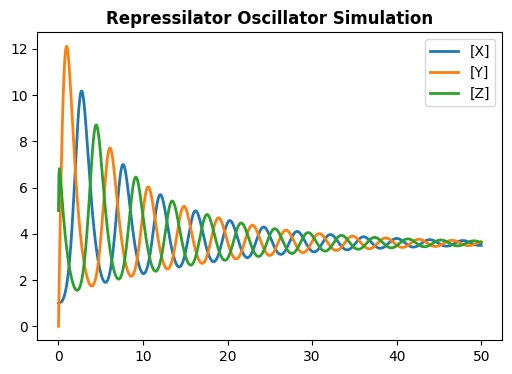

In [26]:
# ============================================================
# REPRESSILATOR MODEL (Synthetic Oscillator)
# Elowitz & Leibler, 2000
# ============================================================

model = te.loada("""
model repressilator()

  // ======================================================
  // Species = Protein concentrations
  // X represses Y
  // Y represses Z
  // Z represses X
  // ======================================================
  species X, Y, Z;

  // ======================================================
  // Parameters
  // k   = maximum production rate
  // d   = degradation rate of proteins
  // K   = repression threshold (affinity)
  // n   = Hill coefficient (cooperativity)
  // ======================================================
  k = 50;
  d = 1;
  K = 1;
  n = 2;

  // ======================================================
  // Reactions:
  // Production is repressed by previous protein in the cycle
  // X' = k / (1 + (Z/K)^n) - d*X
  // Y' = k / (1 + (X/K)^n) - d*Y
  // Z' = k / (1 + (Y/K)^n) - d*Z
  // ======================================================

  J1: -> X; k / (1 + (Z/K)^n);
  J2: -> Y; k / (1 + (X/K)^n);
  J3: -> Z; k / (1 + (Y/K)^n);

  // Degradation
  J4: X -> ; d * X;
  J5: Y -> ; d * Y;
  J6: Z -> ; d * Z;

end
""")

def new_model_repressilator():
    return te.loada(model.getAntimony())
# ============================================================
# Initial conditions
# Oscillations often require asymmetric start
# ============================================================

model.X = 1
model.Y = 0
model.Z = 5

# ============================================================
# Simulation
# ============================================================

result = model.simulate(0, 50, 1000)
model.plot(result, title="Repressilator Oscillator Simulation")


In [27]:
# ============================================================
# LOCAL SENSITIVITY ANALYSIS FOR REPRESSILATOR (OSCILLATOR)
# ============================================================

def oscillation_amplitude(m):
    """
    Compute amplitude of oscillation for X.
    We simulate long enough for oscillations to appear.
    """
    result = m.simulate(0, 200, 2000)  # long enough to see full oscillations
    X = result[:, 1]  # X is the first species column after time
    return np.max(X) - np.min(X)


params = ["k", "d", "K", "n"]   # repressilator parameters
sens_local_osc = {}

print("\n=== LOCAL SENSITIVITY ANALYSIS (OSCILLATOR) ===\n")

# Baseline model
baseline_model = new_model_repressilator()   # new model loader for oscillator
baseline_model.X = 1
baseline_model.Y = 0
baseline_model.Z = 5

baseline = oscillation_amplitude(baseline_model)

print(f"Baseline oscillation amplitude (X) = {baseline}")

# Sensitivity calculation
for p in params:
    m = new_model_repressilator()

    # same initial conditions
    m.X = 1
    m.Y = 0
    m.Z = 5

    value = m.getValue(p)
    delta = 0.01 * value if value != 0 else 0.01

    m.setValue(p, value + delta)
    perturbed = oscillation_amplitude(m)

    sensitivity = (perturbed - baseline) / delta
    sens_local_osc[p] = sensitivity

    print(f"Sensitivity dAmp/d{p} = {sensitivity}")



=== LOCAL SENSITIVITY ANALYSIS (OSCILLATOR) ===

Baseline oscillation amplitude (X) = 9.173951560261896
Sensitivity dAmp/dk = 0.12066642689909912
Sensitivity dAmp/dd = -5.13154803915441
Sensitivity dAmp/dK = 2.3265820188708375
Sensitivity dAmp/dn = 11.312483626259695


In [12]:
# ============================================================
# GLOBAL SENSITIVITY (SOBOL) FOR REPRESSILATOR
# ============================================================

print("\n=== GLOBAL SENSITIVITY ANALYSIS (OSCILLATOR - SOBOL) ===\n")

problem_osc = {
    "num_vars": 4,
    "names": ["k", "d", "K", "n"],
    "bounds": [
        [10, 100],   # k
        [0.1,  5],   # d
        [0.5,  10],  # K
        [1,    4],   # n
    ]
}

def evaluate_oscillator(params):
    """
    Sobol evaluation function for oscillator.
    Computes amplitude of X after simulation.
    Much faster and more stable than steady-state.
    """
    m = new_model_repressilator()
    m.X = 1
    m.Y = 0
    m.Z = 5

    # unpack parameters
    m.k, m.d, m.K, m.n = params

    try:
        result = m.simulate(0, 150, 1500)
        X = result[:, 1]
        return np.max(X) - np.min(X)
    except:
        return 0.0   # safe fallback to avoid NaNs


# ---------------------------
# SOBOL SAMPLING
# ---------------------------

param_values = saltelli.sample(problem_osc, 512, calc_second_order=False)

# Evaluate model for each sample
Y = np.array([evaluate_oscillator(p) for p in param_values])

# If any NaNs appear (rare), replace with mean
if np.any(np.isnan(Y)):
    Y = np.nan_to_num(Y, nan=np.nanmean(Y))


# ---------------------------
# SOBOL ANALYSIS
# ---------------------------

Si = sobol.analyze(problem_osc, Y, calc_second_order=False, print_to_console=True)

print("\nSobol Sensitivity (S1 and ST):")
for name, s1, st in zip(problem_osc["names"], Si["S1"], Si["ST"]):
    print(f"{name}: S1={s1:.4f}, ST={st:.4f}")


=== GLOBAL SENSITIVITY ANALYSIS (OSCILLATOR - SOBOL) ===



C:\Users\grilj\AppData\Local\Temp\ipykernel_70312\3921718015.py:44: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`



         ST   ST_conf
k  0.209019  0.147067
d  1.061959  0.629498
K  0.009727  0.006473
n  0.394642  0.247415
         S1   S1_conf
k  0.010374  0.043818
d  0.455484  0.314044
K  0.012580  0.033588
n  0.073542  0.072204

Sobol Sensitivity (S1 and ST):
k: S1=0.0104, ST=0.2090
d: S1=0.4555, ST=1.0620
K: S1=0.0126, ST=0.0097
n: S1=0.0735, ST=0.3946



=== MORRIS GLOBAL SENSITIVITY (OSCILLATOR) ===

           mu     mu_star       sigma  mu_star_conf
k   63.571348   63.571348  146.672221     21.233146
d -128.633245  128.633245  245.476705     32.179300
K   -1.867650    9.513283   20.765016      2.892549
n   95.686272   95.686272  227.107846     29.823418

=== Morris μ* (Overall Importance) ===
k: μ* = 63.5713
d: μ* = 128.6332
K: μ* = 9.5133
n: μ* = 95.6863

=== Morris σ (Nonlinearity / Interaction) ===
k: σ = 146.6722
d: σ = 245.4767
K: σ = 20.7650
n: σ = 227.1078


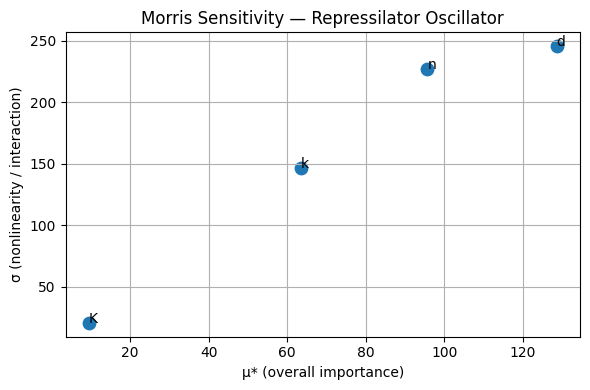

In [28]:
# ============================================================
# MORRIS GLOBAL SENSITIVITY ANALYSIS (OSCILLATOR)
# ============================================================

problem_osc = {
    "num_vars": 4,
    "names": ["k", "d", "K", "n"],
    "bounds": [
        [10, 100],   # k  (production)
        [0.1,  3],   # d  (degradation)
        [0.5,  5],   # K  (threshold)
        [1,    4],   # n  (Hill coefficient)
    ],
}

# ------------------------------------------------------------
# Metric: oscillation amplitude of X
# ------------------------------------------------------------

def metric_amplitude_X(m, t_end=150, n_points=1500):
    r = m.simulate(0, t_end, n_points)
    X = r[:, 1]  # column 1 = X
    return np.max(X) - np.min(X)

# ------------------------------------------------------------
# Morris evaluation function
# ------------------------------------------------------------

def evaluate_oscillator_morris(params):
    m = new_model_repressilator()

    # fixed initial conditions (important for oscillations)
    m.X = 1
    m.Y = 0
    m.Z = 5

    # unpack parameters
    m.k, m.d, m.K, m.n = params

    try:
        return metric_amplitude_X(m)
    except:
        return 0.0

# ------------------------------------------------------------
# Run Morris sampling
# ------------------------------------------------------------

print("\n=== MORRIS GLOBAL SENSITIVITY (OSCILLATOR) ===\n")

morris_samples = morris.sample(
    problem_osc,
    N=200,        # trajectories
    num_levels=8
)

# Evaluate model
Y_morris = np.array([evaluate_oscillator_morris(p) for p in morris_samples])

# Morris allows filtering NaNs
valid = ~np.isnan(Y_morris)
morris_samples = morris_samples[valid]
Y_morris = Y_morris[valid]

# ------------------------------------------------------------
# Morris analysis
# ------------------------------------------------------------

morris_results = morris_analyze.analyze(
    problem_osc,
    morris_samples,
    Y_morris,
    print_to_console=True
)

# ------------------------------------------------------------
# Print results
# ------------------------------------------------------------

print("\n=== Morris μ* (Overall Importance) ===")
for name, mu in zip(problem_osc["names"], morris_results["mu_star"]):
    print(f"{name}: μ* = {mu:.4f}")

print("\n=== Morris σ (Nonlinearity / Interaction) ===")
for name, sig in zip(problem_osc["names"], morris_results["sigma"]):
    print(f"{name}: σ = {sig:.4f}")

# ------------------------------------------------------------
# Morris μ*–σ plot (highly recommended)
# ------------------------------------------------------------

plt.figure(figsize=(6, 4))
plt.scatter(morris_results["mu_star"], morris_results["sigma"], s=80)

for i, name in enumerate(problem_osc["names"]):
    plt.text(
        morris_results["mu_star"][i],
        morris_results["sigma"][i],
        name
    )

plt.xlabel("μ* (overall importance)")
plt.ylabel("σ (nonlinearity / interaction)")
plt.title("Morris Sensitivity — Repressilator Oscillator")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feed-forward motif

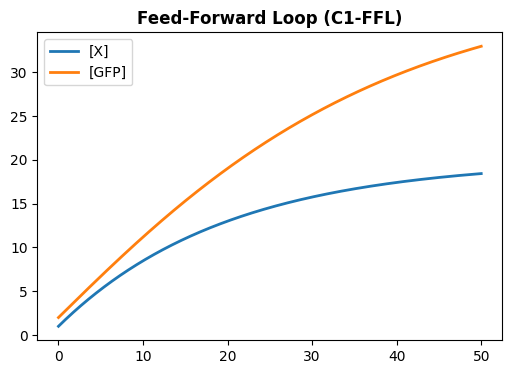

In [29]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# COHERENT FEED-FORWARD LOOP (C1-FFL)
# ============================================================

ffl_antimony = """
model feedforward_loop
// Species
Input = 10;
X = 0;
GFP = 0;

// Parameters
k1 = 0.1; // Input forms X (slow path)
k2 = 0.05; // X forms GFP (slow path)
k3 = 0.1; // Input directly forms GFP (fast path)
k_deg_x = 0.05; // degradation of X
k_deg_GFP = 0.05; // degradation of GFP

// Reactions
J0: -> X; k1*Input // Input slowly activates X
J1: X -> ; k_deg_x*X // X degrades over time
J2: -> GFP; (k2*X+k3*Input) // GFP made from both X and Input
J3: GFP -> ; k_deg_GFP*GFP // GFP degrades naturally
end
"""


model = te.loada(ffl_antimony)

def new_model_ffl():
    return te.loada(ffl_antimony)


model.reset()
model.Input = 10   # input ON
model.X = 1
model.GFP = 2

result = model.simulate(0, 50, 1000)
model.plot(result, title="Feed-Forward Loop (C1-FFL)")


In [19]:
# ============================================================
# LOCAL SENSITIVITY ANALYSIS (FFL)
# Metric: GFP at final time (approx steady-state)
# ============================================================

def metric_GFP_final(m, t_end=50, n_points=500):
    """
    Returns GFP value at the end of simulation.
    Columns: time, X, GFP  (Input is a boundary species/parameter here)
    """
    r = m.simulate(0, t_end, n_points)
    return r[-1, 2]  # GFP is column 2 (time=0, X=1, GFP=2)

params = ["k1", "k2", "k3", "k_deg_x", "k_deg_GFP", "Input"]
sens_local_ffl = {}

print("\n=== LOCAL SENSITIVITY ANALYSIS (FFL) ===\n")

# Baseline
baseline_model = new_model_ffl()
baseline_model.reset()
baseline_model.Input = 10
baseline_model.X = 0
baseline_model.GFP = 0

baseline = metric_GFP_final(baseline_model)
print(f"Baseline GFP(t_end) = {baseline}")

# Finite-difference sensitivities
for p in params:
    m = new_model_ffl()
    m.reset()
    m.Input = 10
    m.X = 1
    m.GFP = 2

    value = m.getValue(p)
    delta = 0.01 * value if value != 0 else 0.01  # 1% perturbation (or small absolute)

    m.setValue(p, value + delta)
    perturbed = metric_GFP_final(m)

    sensitivity = (perturbed - baseline) / delta
    sens_local_ffl[p] = sensitivity

    print(f"Sensitivity dGFP_final/d{p} = {sensitivity}")



=== LOCAL SENSITIVITY ANALYSIS (FFL) ===

Baseline GFP(t_end) = 32.612432044799306
Sensitivity dGFP_final/dk1 = 511.864471406021
Sensitivity dGFP_final/dk2 = 1027.8355461735343
Sensitivity dGFP_final/dk3 = 552.9069558264723
Sensitivity dGFP_final/dk_deg_x = 552.0522885477135
Sensitivity dGFP_final/dk_deg_GFP = 260.67850813174687
Sensitivity dGFP_final/dInput = 6.954470077505377


In [20]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np

# ============================================================
# GLOBAL SENSITIVITY (SOBOL) FOR FFL
# Metric: GFP at final time (t_end)
# ============================================================

print("\n=== GLOBAL SENSITIVITY ANALYSIS (FFL - SOBOL) ===\n")

problem_ffl = {
    "num_vars": 6,
    "names": ["k1", "k2", "k3", "k_deg_x", "k_deg_GFP", "Input"],
    "bounds": [
        [0.01, 0.5],   # k1
        [0.005, 0.2],  # k2
        [0.01, 0.5],   # k3
        [0.005, 0.2],  # k_deg_x
        [0.005, 0.2],  # k_deg_GFP
        [1, 20],       # Input
    ],
}

def evaluate_ffl(params, t_end=50, n_points=300):
    m = new_model_ffl()
    m.reset()

    # initial conditions (same as your simulation)
    m.X = 1
    m.GFP = 2

    # set parameters
    m.k1, m.k2, m.k3, m.k_deg_x, m.k_deg_GFP, m.Input = params

    try:
        r = m.simulate(0, t_end, n_points)
        return r[-1, 2]  # GFP final
    except:
        return 0.0  # safe fallback (don’t drop samples for Sobol)

# ---------------------------
# SOBOL SAMPLING (first-order + total)
# ---------------------------
N = 512  # reduce to 256 if it’s slow
param_values = saltelli.sample(problem_ffl, N, calc_second_order=False)

# Evaluate model
Y = np.array([evaluate_ffl(p) for p in param_values])

# Keep length intact; replace NaNs if they appear
if np.any(np.isnan(Y)):
    Y = np.nan_to_num(Y, nan=np.nanmean(Y))

# ---------------------------
# SOBOL ANALYSIS
# ---------------------------
Si = sobol.analyze(problem_ffl, Y, calc_second_order=False, print_to_console=True)

print("\nSobol Sensitivity (S1 and ST):")
for name, s1, st in zip(problem_ffl["names"], Si["S1"], Si["ST"]):
    print(f"{name}: S1={s1:.4f}, ST={st:.4f}")



=== GLOBAL SENSITIVITY ANALYSIS (FFL - SOBOL) ===



C:\Users\grilj\AppData\Local\Temp\ipykernel_34592\3833135184.py:46: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`



                 ST   ST_conf
k1         0.152694  0.038578
k2         0.151469  0.060665
k3         0.070773  0.026180
k_deg_x    0.191603  0.093360
k_deg_GFP  0.465282  0.141400
Input      0.353090  0.095081
                 S1   S1_conf
k1         0.073735  0.053482
k2         0.048163  0.027602
k3         0.022042  0.031707
k_deg_x    0.067626  0.046792
k_deg_GFP  0.312582  0.106031
Input      0.174849  0.055083

Sobol Sensitivity (S1 and ST):
k1: S1=0.0737, ST=0.1527
k2: S1=0.0482, ST=0.1515
k3: S1=0.0220, ST=0.0708
k_deg_x: S1=0.0676, ST=0.1916
k_deg_GFP: S1=0.3126, ST=0.4653
Input: S1=0.1748, ST=0.3531



=== MORRIS GLOBAL SENSITIVITY (FEED-FORWARD LOOP) ===

                   mu     mu_star       sigma  mu_star_conf
k1         100.414274  100.414274  166.798276     21.478437
k2          81.678661   81.678661  131.184252     16.439227
k3          76.660396   76.660396   84.973925     12.455968
k_deg_x    -92.420499   92.420499  165.869445     18.941467
k_deg_GFP -164.744418  164.744418  201.782465     28.594064
Input      136.129391  136.129391  137.393784     19.657339

=== Morris μ* (Overall Importance) ===
k1: μ* = 100.4143
k2: μ* = 81.6787
k3: μ* = 76.6604
k_deg_x: μ* = 92.4205
k_deg_GFP: μ* = 164.7444
Input: μ* = 136.1294

=== Morris σ (Nonlinearity / Interaction) ===
k1: σ = 166.7983
k2: σ = 131.1843
k3: σ = 84.9739
k_deg_x: σ = 165.8694
k_deg_GFP: σ = 201.7825
Input: σ = 137.3938


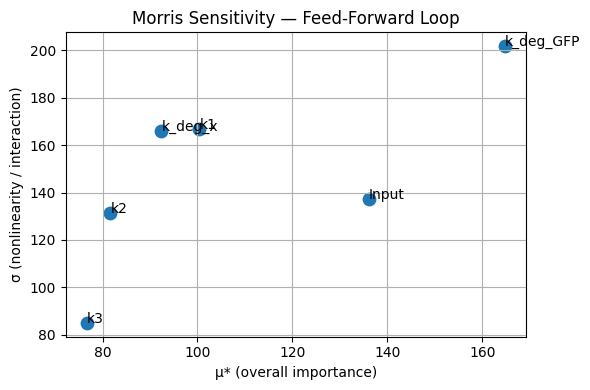

In [30]:
# ============================================================
# MORRIS GLOBAL SENSITIVITY ANALYSIS (FFL)
# ============================================================

problem_ffl = {
    "num_vars": 6,
    "names": ["k1", "k2", "k3", "k_deg_x", "k_deg_GFP", "Input"],
    "bounds": [
        [0.01, 0.5],   # k1
        [0.005, 0.2],  # k2
        [0.01, 0.5],   # k3
        [0.005, 0.2],  # k_deg_x
        [0.005, 0.2],  # k_deg_GFP
        [1, 20],       # Input
    ],
}

# ------------------------------------------------------------
# Metric: GFP at final time (fast & stable)
# ------------------------------------------------------------

def metric_GFP_final(m, t_end=50, n_points=300):
    r = m.simulate(0, t_end, n_points)
    return r[-1, 2]  # column 2 = GFP

# ------------------------------------------------------------
# Morris evaluation function
# ------------------------------------------------------------

def evaluate_ffl_morris(params):
    m = new_model_ffl()
    m.reset()

    # fixed initial conditions
    m.X = 1
    m.GFP = 2

    # unpack parameters
    m.k1, m.k2, m.k3, m.k_deg_x, m.k_deg_GFP, m.Input = params

    try:
        return metric_GFP_final(m)
    except:
        return 0.0

# ------------------------------------------------------------
# Run Morris sampling
# ------------------------------------------------------------

print("\n=== MORRIS GLOBAL SENSITIVITY (FEED-FORWARD LOOP) ===\n")

morris_samples = morris.sample(
    problem_ffl,
    N=200,        # number of trajectories
    num_levels=8
)

Y_morris = np.array([evaluate_ffl_morris(p) for p in morris_samples])

# Morris allows NaN filtering
valid = ~np.isnan(Y_morris)
morris_samples = morris_samples[valid]
Y_morris = Y_morris[valid]

# ------------------------------------------------------------
# Morris analysis
# ------------------------------------------------------------

morris_results = morris_analyze.analyze(
    problem_ffl,
    morris_samples,
    Y_morris,
    print_to_console=True
)

# ------------------------------------------------------------
# Print results
# ------------------------------------------------------------

print("\n=== Morris μ* (Overall Importance) ===")
for name, mu in zip(problem_ffl["names"], morris_results["mu_star"]):
    print(f"{name}: μ* = {mu:.4f}")

print("\n=== Morris σ (Nonlinearity / Interaction) ===")
for name, sig in zip(problem_ffl["names"], morris_results["sigma"]):
    print(f"{name}: σ = {sig:.4f}")

# ------------------------------------------------------------
# Morris μ*–σ plot (excellent for report)
# ------------------------------------------------------------

plt.figure(figsize=(6, 4))
plt.scatter(morris_results["mu_star"], morris_results["sigma"], s=80)

for i, name in enumerate(problem_ffl["names"]):
    plt.text(
        morris_results["mu_star"][i],
        morris_results["sigma"][i],
        name
    )

plt.xlabel("μ* (overall importance)")
plt.ylabel("σ (nonlinearity / interaction)")
plt.title("Morris Sensitivity — Feed-Forward Loop")
plt.grid(True)
plt.tight_layout()
plt.show()